# Forward modeling of the emission spectrum using Fe I line list from Kurucz

Tako Ishikawa, Hajime Kawahara  
last update: 2024/07/14  
created: : 2022/04/22  

This notebook demonstrates how to use Kurucz database, not using `opa`.
Currently, `opa` cannot be used for metal lines yet.

In [1]:
from exojax.utils.grids import wavenumber_grid
from exojax.database import atomll 
from exojax.database.hitran  import doppler_sigma, line_strength 
from exojax.opacity.initspec import init_lpf
from exojax.opacity.lpf import xsmatrix
from exojax.rt.layeropacity import layer_optical_depth, layer_optical_depth_Hminus, layer_optical_depth_CIA
import matplotlib.pyplot as plt
from jax import vmap, jit
import numpy as np

/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


Sets a wavenumber grid

In [2]:
#We set a wavenumber grid using wavenumber_grid.
nu_grid, wav, reso = wavenumber_grid(10380, 10430, 4500, xsmode="lpf", unit="AA", wavelength_order="ascending") 

xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: xsmode=lpf
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  ascending  *** order


/home/kawahara/exojax/src/exojax/utils.grids.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(


Sets a T-P profile  and partial pressures

rtsolver:  ibased
Intensity-based n-stream solver, isothermal layer (e.g. NEMESIS, pRT like)


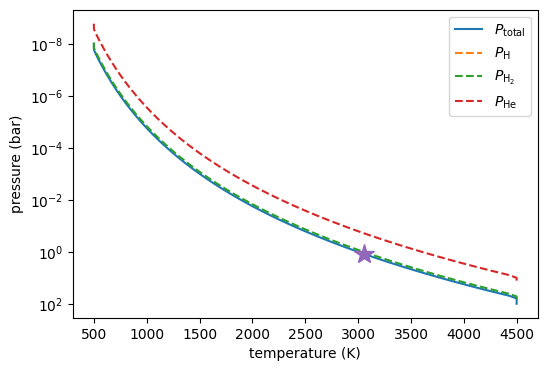

In [4]:
from exojax.rt.atmrt import ArtEmisPure
nlayer = 100
T0 = 3000.0  # 10000. #3000. #1295.0 #K
alpha = 0.1
Tlow = 500.0
Thigh = 4500.0
art = ArtEmisPure(nu_grid=nu_grid, pressure_top=1.e-8, pressure_btm=1.e2, nlayer=nlayer)
art.change_temperature_range(Tlow, Thigh)
Tarr = art.powerlaw_temperature(T0, alpha)
Parr = art.pressure
dParr = art.dParr

H_He_HH_VMR = [0.0, 0.16, 0.84]  # typical quasi-"solar-fraction"
PH = Parr * H_He_HH_VMR[0]
PHe = Parr * H_He_HH_VMR[1]
PHH = Parr * H_He_HH_VMR[2]

fig = plt.figure(figsize=(6, 4))
plt.plot(Tarr, Parr, label="$P_\mathrm{total}$")
plt.plot(Tarr, PH, "--", label="$P_\mathrm{H}$")
plt.plot(Tarr, PHH, "--", label="$P_\mathrm{H_2}$")
plt.plot(Tarr, PHe, "--", label="$P_\mathrm{He}$")
plt.plot(Tarr[80], Parr[80], marker="*", markersize=15)
plt.yscale("log")
plt.xlabel("temperature (K)")
plt.ylabel("pressure (bar)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Load a Kurucz line list for neutral iron (Fe I)  
(Downloaded from [Index of /linelists/gfall](http://kurucz.harvard.edu/linelists/gfall/))

In [5]:
"""
    kuruczlines:  fullpath to the input line list obtained from Kurucz linelists (http://kurucz.harvard.edu/linelists/):
        For a example in this notebook, gf2600.all downloaded from (http://kurucz.harvard.edu/linelists/gfall/) is used.
"""
from exojax.database.moldb  import AdbKurucz
kuruczlines = '.database/gf2600.all'
adbK = AdbKurucz(kuruczlines, nu_grid)

Reading Kurucz file


/home/kawahara/exojax/src/exojax/spec/atomllapi.py:616: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ionE = float(


Relative partition function

In [6]:
#Computing the relative partition function,
qt_284 = vmap(adbK.QT_interp_284)(Tarr)
qt_K = qt_284[:, adbK.QTmask]
qr_K = qt_K / adbK.QTref_284[adbK.QTmask]

/home/kawahara/exojax/src/exojax/spec/moldb.py:577: FutureWarning: Deprecated Use `atomll.interp_QT_284` instead
  warnings.warn(warn_msg, FutureWarning)


Lorentzian width, Doppler width, and Line strength

In [7]:
# volume mixing ratio (VMR) for e-
vmre = 10**-7 # assume an arbitrary uniform value here

from exojax.atm.idealgas import number_density
narr = number_density(Parr, Tarr)
number_density_e = vmre * narr

Applies JIT to gamma, sigma, and line strength

In [9]:
gammaLM_K = jit(vmap(atomll.gamma_vald3,(0,0,0,0,None,None,None,None,None,None,None,None,None,None,None,0)))\
        (Tarr, PH, PHH, PHe, adbK.ielem, adbK.iion, \
                adbK.dev_nu_lines, adbK.elower, adbK.eupper, adbK.atomicmass, adbK.ionE, \
                adbK.gamRad, adbK.gamSta, adbK.vdWdamp, 1.0, number_density_e)

sigmaDM_K = jit(vmap(doppler_sigma,(None,0,None)))\
    (adbK.nu_lines, Tarr, adbK.atomicmass)

#from exojax.utils.constants import Tref_original

SijM_K = jit(vmap(line_strength,(0,None,None,None,0,None)))\
    (Tarr, adbK.logsij0, adbK.nu_lines, adbK.elower, qr_K, adbK.Tref)

Initialization of LPF.

In [10]:
numatrix_K = init_lpf(adbK.nu_lines, nu_grid)

Stellar parameters

In [11]:
#Parameters of Objects
Rp = 0.36*10 #R_sun*10
Mp = 0.37*1e3 #M_sun*1e3
g = 2478.57730044555*Mp/Rp**2
print('logg: '+str(np.log10(g)))

logg: 4.849799190511717


Volume mixing ratio of Fe (applying the Solar value)

In [12]:
VMR_Fe = atomll.get_VMR_uspecies(np.array([[26,1]]))

Cross section and delta tau

In [13]:
mmw = 2.33  # mean molecular weight

xsm_K = xsmatrix(numatrix_K, sigmaDM_K, gammaLM_K, SijM_K)
dtaua_K = layer_optical_depth(dParr, xsm_K, VMR_Fe * np.ones_like(Tarr), mmw, g)

Delta tau for CIA and Hminus

In [14]:
from exojax.database.contdb  import CdbCIA
cdbH2H2 = CdbCIA('.database/H2-H2_2011.cia', nu_grid)

vmrh=H_He_HH_VMR[0]
vmre=vmrh*1e-5
vmrH2=H_He_HH_VMR[2] #(0.74*mmw/molinfo.molmass("H2")) #VMR

dtau_Hm = layer_optical_depth_Hminus(nu_grid, Tarr, Parr, dParr, vmre, vmrh, mmw, g)
dtaucH2H2=layer_optical_depth_CIA(nu_grid,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)


H2-H2


Total dtau

In [15]:
dtau_K = dtaua_K + dtau_Hm + dtaucH2H2

Contribution function using exojax.plot.atmplot 

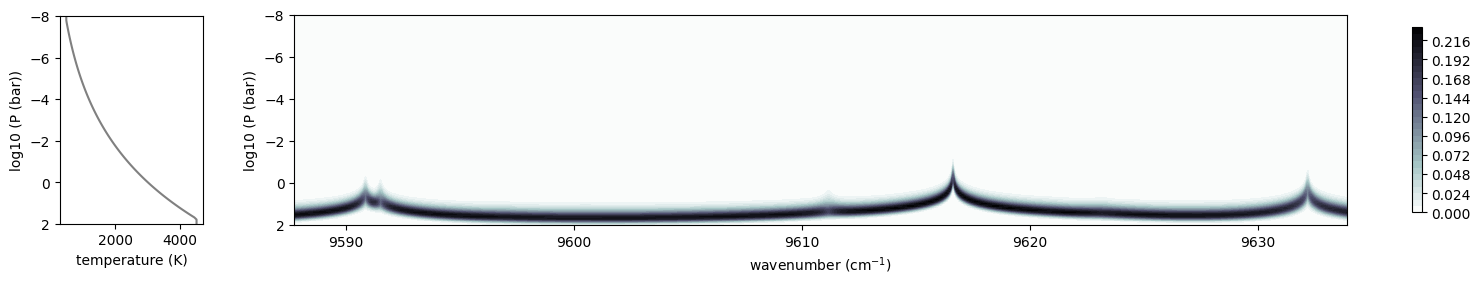

In [16]:
from exojax.plot.atmplot import plotcf
plotcf(nu_grid, dtau_K, Tarr, Parr, dParr)
#plt.savefig(path_fig + 'dtau_K.pdf')
plt.show()

Perform a radiative transfer. Here, the source function is the Planck function (multiplied by pi).

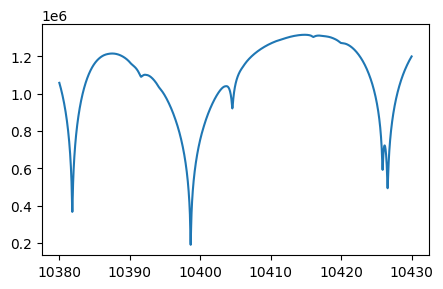

In [17]:
F0_K = art.run(dtau_K, Tarr)

fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1], F0_K)
plt.show()

## Comparison with Fe I lines of VALD3
(c.f. [Forward modeling of the emission spectrum using VALD3](http://secondearths.sakura.ne.jp/exojax/tutorials/metals.html))

In [19]:
"""
    valdlines:  fullpath to the input line list obtained from VALD3 (http://vald.astro.uu.se/):
        For a example in this notebook, the VALD3 request form of "Extract Element" mode was used filling the form "Element [ + ionization ] :" with "Fe 1".
        For more details of VALD data access, please see "Forward modeling for metal line.ipynb" (https://github.com/HajimeKawahara/exojax/blob/master/examples/tutorial/Forward%20modeling%20for%20metal%20line.ipynb)
"""

from exojax.database.moldb  import AdbVald
valdlines = '.database/vald2600.gz'
adbV = AdbVald(valdlines, nu_grid)

Reading VALD file


/home/kawahara/exojax/src/exojax/spec/atomllapi.py:616: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ionE = float(


In [20]:
qt_284 = vmap(adbV.QT_interp_284)(Tarr)
qt_V = qt_284[:, adbV.QTmask]
qr_V = qt_V / adbV.QTref_284[adbV.QTmask]

gammaLM_V = jit(vmap(atomll.gamma_vald3,(0,0,0,0,None,None,None,None,None,None,None,None,None,None,None,0)))\
        (Tarr, PH, PHH, PHe, adbV.ielem, adbV.iion, \
                adbV.dev_nu_lines, adbV.elower, adbV.eupper, adbV.atomicmass, adbV.ionE, \
                adbV.gamRad, adbV.gamSta, adbV.vdWdamp, 1.0, number_density_e)
sigmaDM_V = jit(vmap(doppler_sigma,(None,0,None)))\
    (adbV.nu_lines, Tarr, adbV.atomicmass)
SijM_V = jit(vmap(line_strength,(0,None,None,None,0,None)))\
    (Tarr, adbV.logsij0, adbV.nu_lines, adbV.elower, qr_V, adbV.Tref)

numatrix_V = init_lpf(adbV.nu_lines, nu_grid)

xsm_V = xsmatrix(numatrix_V, sigmaDM_V, gammaLM_V, SijM_V)
dtaua_V = layer_optical_depth(dParr, xsm_V, VMR_Fe * np.ones_like(Tarr), mmw, g)
dtau_V = dtaua_V + dtau_Hm + dtaucH2H2


/home/kawahara/exojax/src/exojax/spec/moldb.py:267: FutureWarning: Deprecated Use `atomll.interp_QT_284` instead
  warnings.warn(warn_msg, FutureWarning)


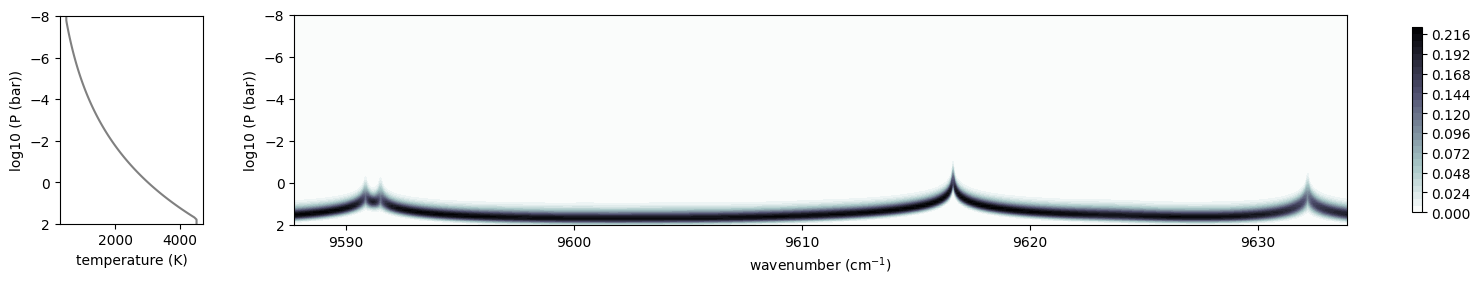

In [21]:
from exojax.plot.atmplot import plotcf
plotcf(nu_grid, dtau_V, Tarr, Parr, dParr)
#plt.savefig(path_fig + 'dtau_V.pdf')
plt.show()

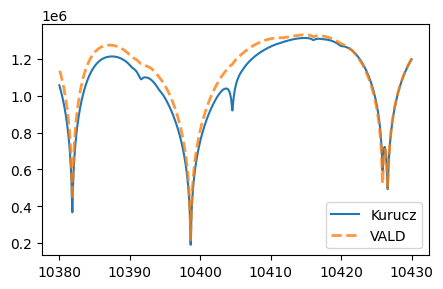

In [22]:
F0_V = art.run(dtau_V, Tarr)

fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1], F0_K, label='Kurucz')
plt.plot(wav[::-1], F0_V, '--', label='VALD', lw=2., alpha=.8)
plt.legend()
#plt.savefig(path_fig + 'comp_F0_KV.pdf')
plt.show()

In [23]:
#Comparison of values
print(1e8/adbK.nu_lines[np.argmax(adbK.logsij0)],  1e8/adbV.nu_lines[np.argmax(adbV.logsij0[20:])+20])
print(adbK.elower[np.argmax(adbK.logsij0)],  adbV.elower[np.argmax(adbV.logsij0[20:])+20])
print(adbK.logsij0[np.argmax(adbK.logsij0)],  adbV.logsij0[np.argmax(adbV.logsij0[20:])+20])
print(adbK.A[np.argmax(adbK.logsij0)],  adbV.A[np.argmax(adbV.logsij0[20:])+20])
print(adbK.vdWdamp[np.argmax(adbK.logsij0)],  adbV.vdWdamp[np.argmax(adbV.logsij0[20:])+20])

10398.644993873695 10398.6434
17550.18 17549.809
-122.76289 -123.187065
4245.6694 2772.9773
-7.76 -7.8
